In [2]:
import cv2
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import gzip
from utils import *

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [19]:
sam = sam_model_registry['default']('./sam_vit_h_4b8939.pth')
sam.to(device)
predictor = SamPredictor(sam)

In [20]:
image = cv2.imread('./images/Dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [21]:
image.shape

(1365, 2048, 3)

In [22]:
predictor.set_image(image)

In [23]:
input_point = np.array([[1200, 800], [1000,700]])
input_label = np.array([1, 1])

In [24]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label,
    multimask_output=True,
)

In [25]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

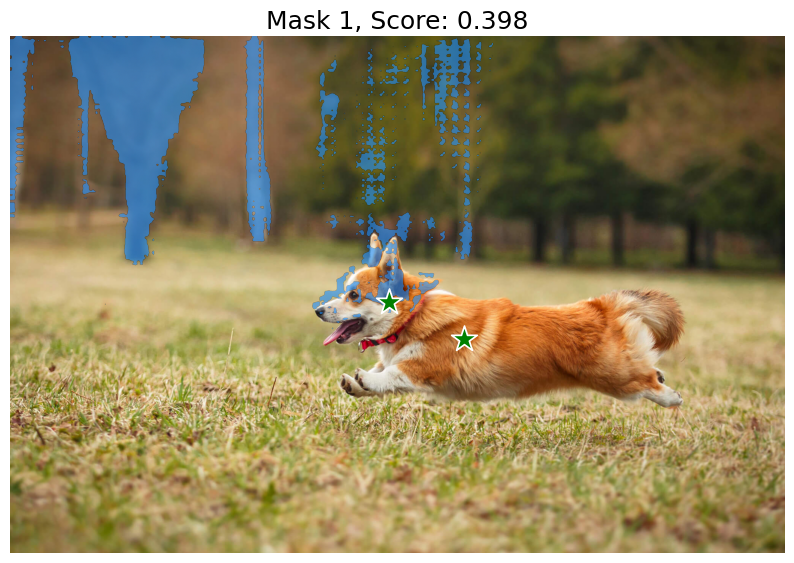

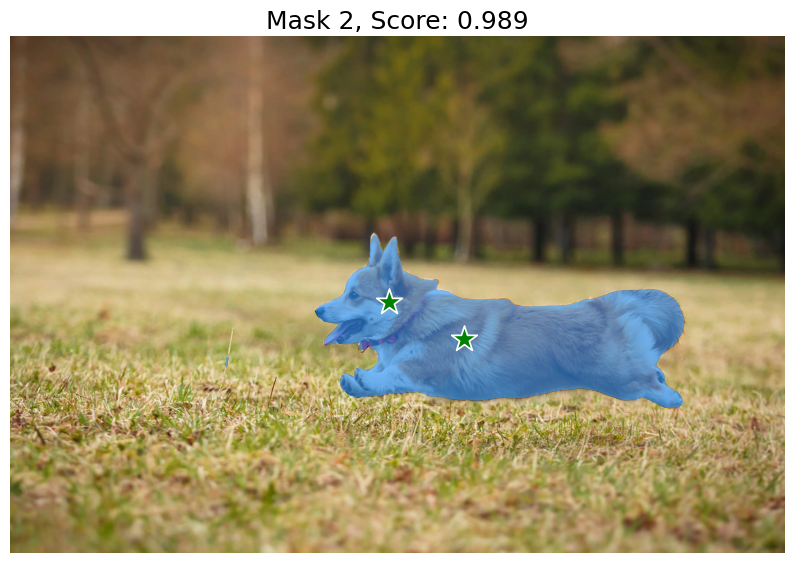

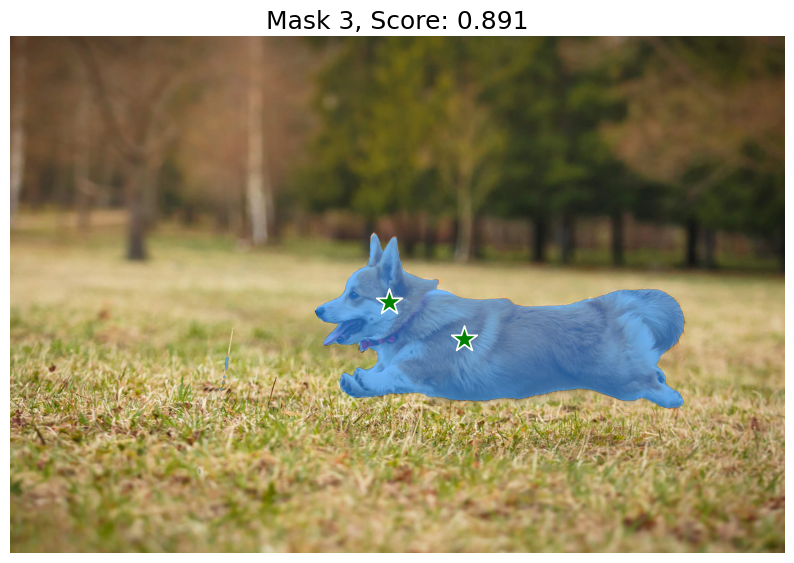

In [26]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [38]:
input_box = np.array([750, 450, 1800, 1000])

masks, _, _ = predictor.predict(box = input_box[None, :])

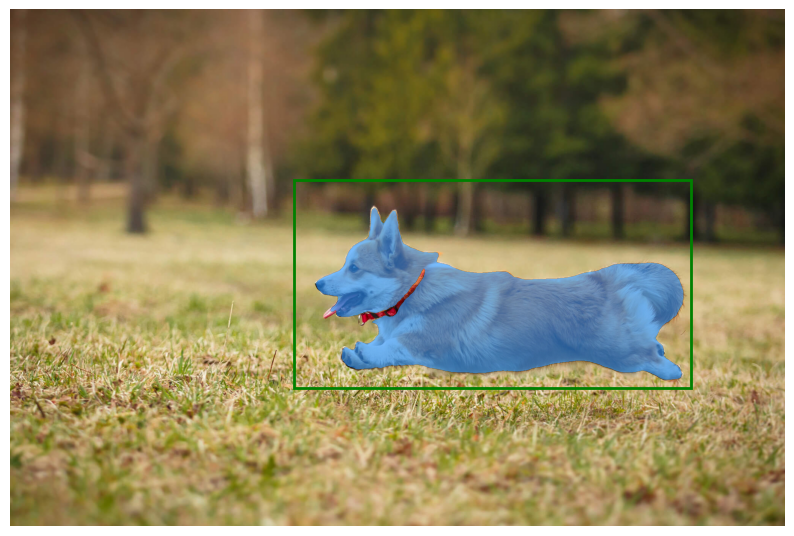

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [52]:
import json

with open('./data/dataset_0.json', 'r') as f:
    dataset = json.load(f)
print(len(dataset['training']))
print(len(dataset['test']))
print(len(dataset['validation']))

24
20
6


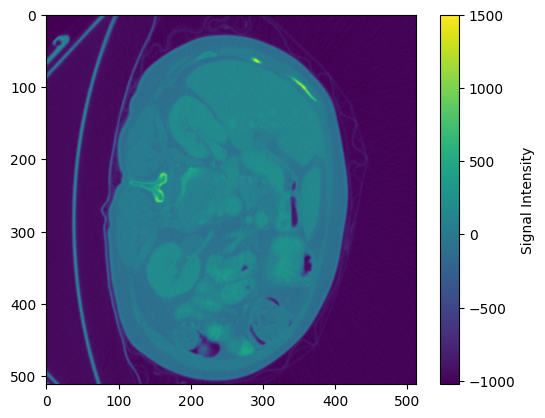

In [53]:
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D

img = nib.load('./data/imagesTr/img0001.nii.gz').get_fdata()

plt.imshow(img[:, :, 100])
plt.colorbar(label='Signal Intensity')

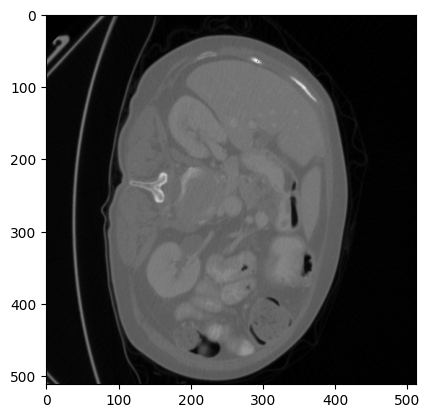

In [68]:
cvt_img = cvt2uint8(img[:, :, 100])

plt.imshow(cvt_img)
predictor.set_image(cvt_img)

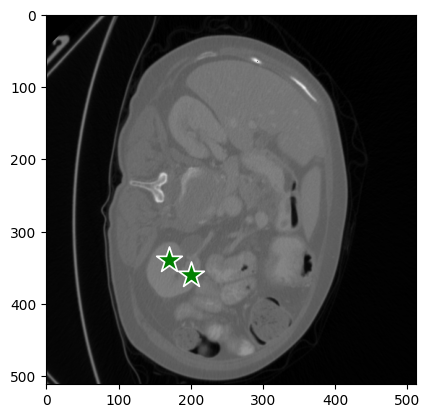

In [93]:
input_point = np.array([[200, 360], [170, 340]])
input_label = np.array([1, 1])

plt.imshow(cvt_img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [94]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True 
)

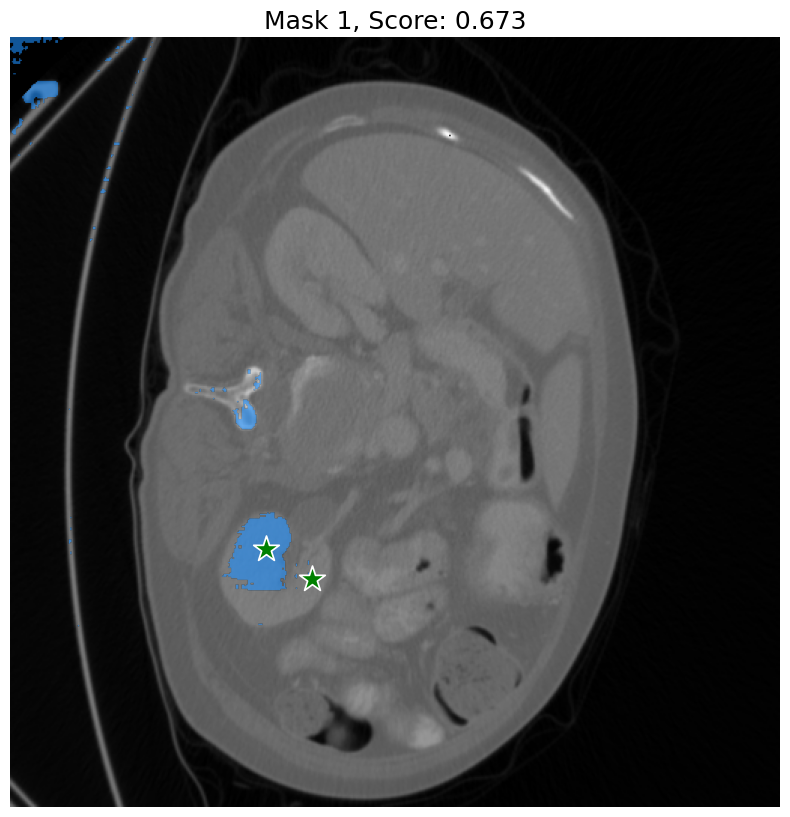

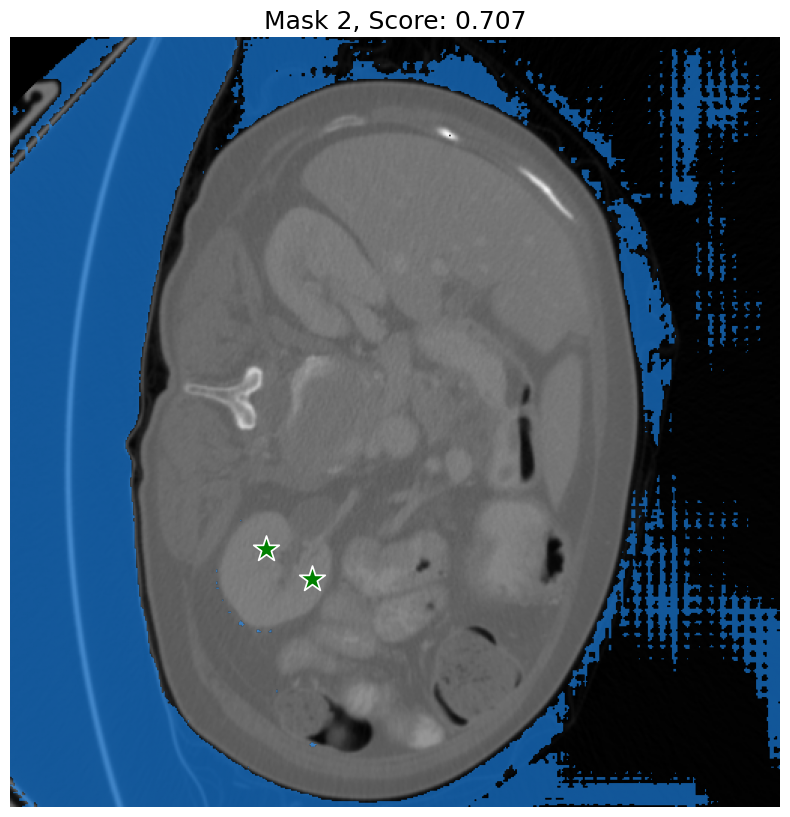

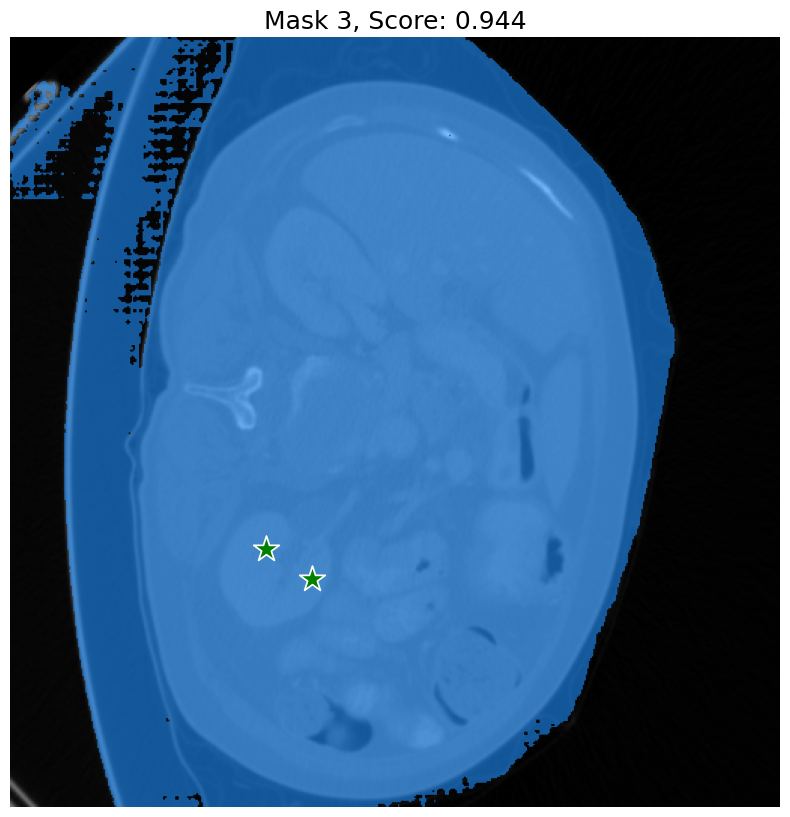

In [95]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(cvt_img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [14]:
import dataset
from dataset import BTCV2DSliceDataset
from torch.utils.data import DataLoader
import importlib
import prompt_gen
importlib.reload(prompt_gen)
from prompt_gen import *

In [3]:
train_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='training', 
                               preprocess=dataset.to_uint8_rgb)
validation_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='validation', 
                               preprocess=dataset.to_uint8_rgb)

In [27]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [5]:
len(train_loader)

755

In [28]:
batch = next(iter(train_loader))
boxes = box_prompt(batch['label'])

In [29]:
boxes

[{1: [205, 300, 260, 354],
  5: [234, 255, 249, 271],
  6: [145, 117, 328, 290],
  7: [238, 301, 268, 320],
  8: [202, 251, 231, 280],
  9: [230, 211, 257, 240]},
 {},
 {8: [266, 269, 285, 289], 9: [263, 230, 290, 262]},
 {1: [143, 280, 347, 426],
  2: [161, 158, 206, 208],
  4: [249, 166, 278, 190],
  6: [167, 110, 328, 192],
  7: [311, 204, 368, 348],
  8: [212, 249, 228, 266],
  9: [202, 191, 242, 231],
  10: [262, 216, 316, 335],
  11: [256, 209, 317, 288]}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


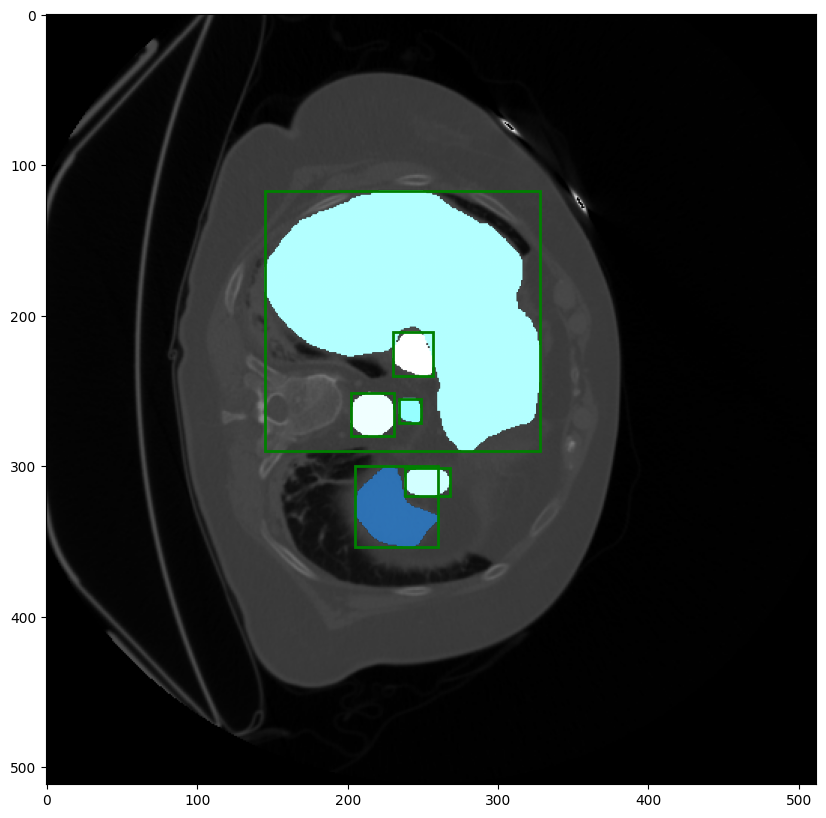

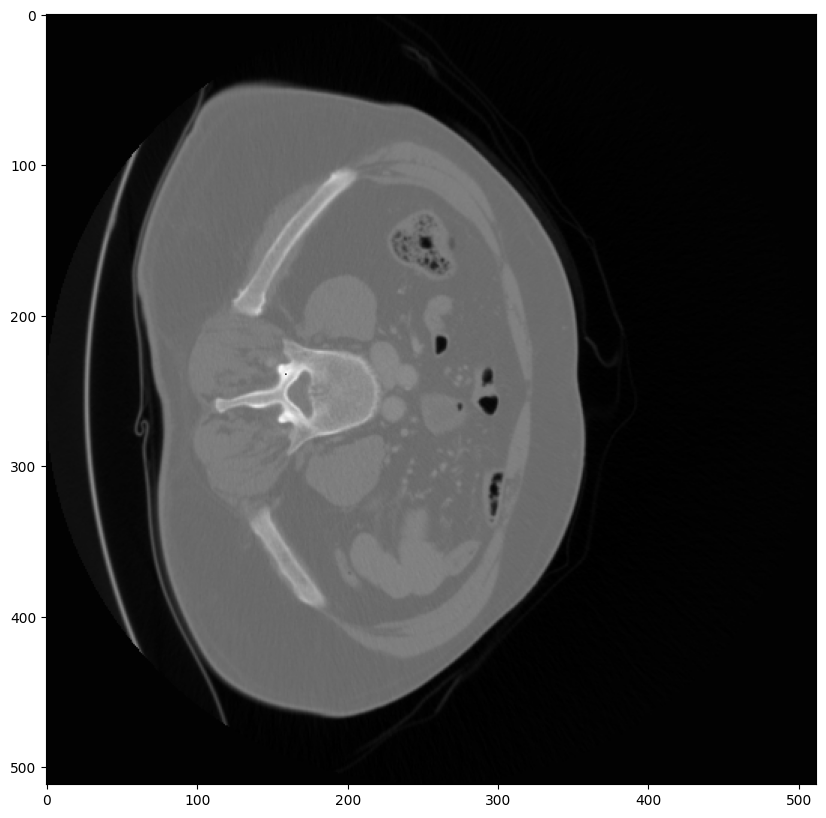

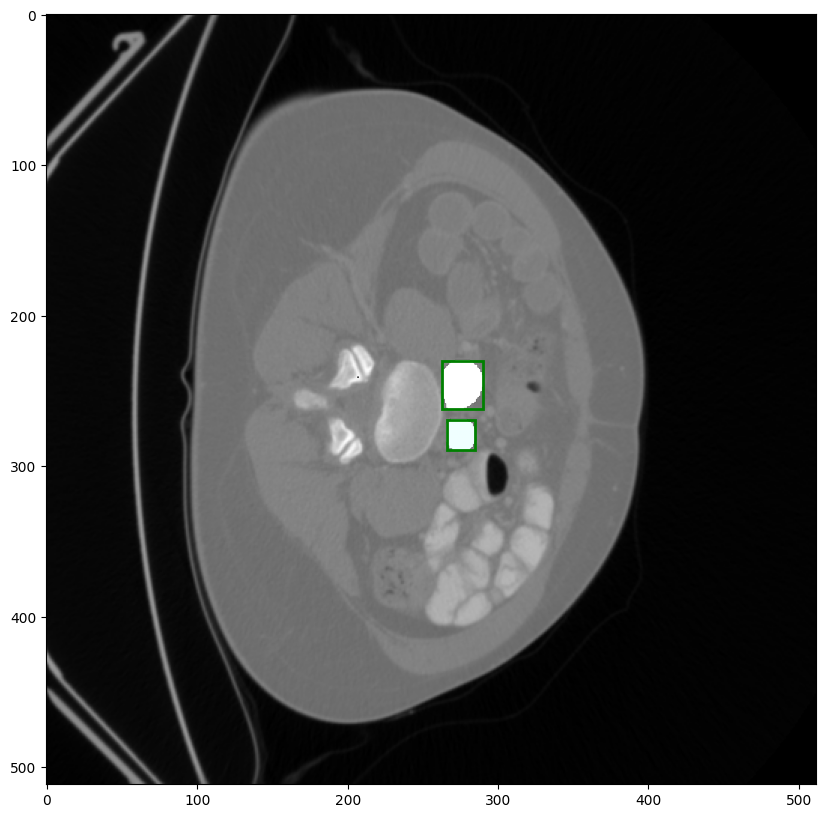

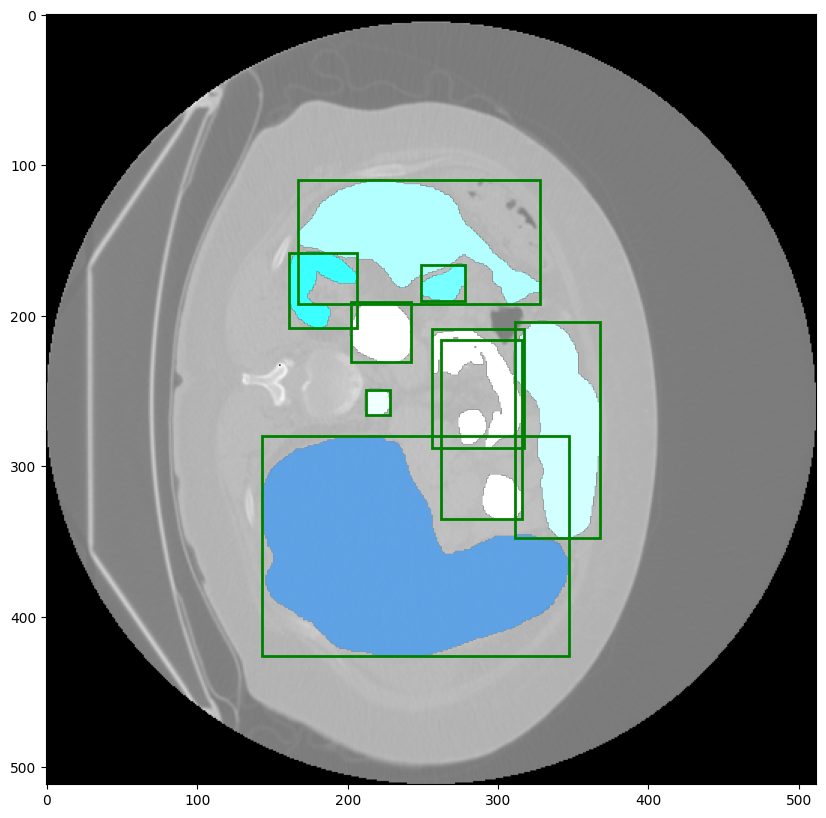

In [30]:
img = batch['image']

for i in range(img.shape[0]):
    plt.figure(figsize=(10,10))
    plt.imshow(img[i])

    show_mask(batch['label'][i], plt.gca())

    bbox = boxes[i]

    for k, b in bbox.items():
        show_box(b, plt.gca())

# Test box input for validation dataset

In [34]:
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)